<a href="https://colab.research.google.com/github/LevBahn/Gross-Pitaevskii-Eigenvalue-problem/blob/main/Gross_Pitaevskii_1D_power_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements supervised weights for approximating the solution to the one-dimensional Gross-Pitavskii equation.

# Import Libraries

In [59]:
%%capture
!pip install pytorch-optimizer
!git clone https://github.com/facebookresearch/optimizers.git
%cd optimizers
!pip install .
%cd ..

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import os
from torch.autograd import grad
from scipy.special import hermite
# from adabelief_pytorch import AdaBelief
from pytorch_optimizer import QHAdam, AdaHessian, Ranger21, SophiaH, Shampoo
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.utils
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Physics Informed Neural Network

In [61]:
class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation.
    """

    def __init__(self, layers, hbar=1.0, m=1.0, mode=0, gamma=1.0, power=1.0):
        """
        Parameters
        ----------
        layers : list of int
            Neural network architecture, each entry defines the number of neurons in that layer.
        hbar : float, optional
            Reduced Planck's constant (default is 1.0).
        m : float, optional
            Mass of the particle (default is 1.0).
        mode : int, optional
            Mode number (default is 0).
        gamma : float, optional
            Interaction strength parameter.
        """
        super().__init__()
        self.layers = layers
        self.network = self.build_network()
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed
        self.mode = mode  # Mode number (n)
        self.gamma = gamma  # Interaction strength parameter
        self.power = power  # power

    def build_network(self):
        """
        Build the neural network with tanh activation functions between layers.
        """
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def weighted_hermite(self, x, n):
        """
        Compute the weighted Hermite polynomial solution for the linear case (gamma = 0).
        """
        H_n = hermite(n)(x.cpu().detach().numpy())  # Hermite polynomial evaluated at x
        norm_factor = (2 ** n * math.factorial(n) * np.sqrt(np.pi)) ** (-0.5)
        weighted_hermite = norm_factor * torch.exp(-x ** 2 / 2) * torch.tensor(H_n, dtype=torch.float32).to(device)
        return weighted_hermite

    def forward(self, inputs):
        """
        Forward pass through the neural network.
        """
        return self.network(inputs)

    def get_complete_solution(self, x, perturbation, mode=0):
        """
        Get the complete solution by combining the base Hermite solution with the neural network perturbation.
        """
        base_solution = self.weighted_hermite(x, mode)
        return base_solution + perturbation

    def compute_potential(self, x, potential_type="harmonic", **kwargs):
        """
        Compute potential function for the 1D domain.
        """
        if potential_type == "harmonic":
            omega = kwargs.get('omega', 1.0)  # Frequency for harmonic potential
            V = 0.5 * omega ** 2 * x ** 2
        elif potential_type == "gaussian":
            a = kwargs.get('a', 0.0)  # Center of the Gaussian
            V = torch.exp(-(x - a) ** 2)
        elif potential_type == "periodic":
            V0 = kwargs.get('V0', 1.0)  # Depth of the potential
            k = kwargs.get('k', 2 * np.pi / 5.0)  # Wave number for periodic potential
            V = V0 * torch.cos(k * x) ** 2
        else:
            raise ValueError(f"Unknown potential type: {potential_type}")
        return V

    def pde_loss(self, p, inputs, predictions, gamma, potential_type="harmonic", precomputed_potential=None):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.
        μψ = -1/2 ∇²ψ + Vψ + γ|ψ|²ψ
        """
        # Get the complete solution (base + perturbation)
        u = self.get_complete_solution(inputs, predictions, self.mode)

        # Compute derivatives with respect to x
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=inputs,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=inputs,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True
        )[0]

        # Compute potential
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)

        # Calculate chemical potential
        kinetic = -0.5 * u_xx
        potential = V * u
        interaction = gamma * u ** p

        numerator = torch.mean(u * (kinetic + potential + interaction))
        denominator = torch.mean(u ** 2)
        lambda_pde = numerator / denominator

        # Residual of the 1D Gross-Pitaevskii equation
        pde_residual = kinetic + potential + interaction - lambda_pde * u

        # PDE loss (mean squared residual)
        pde_loss = torch.mean(pde_residual ** 2)

        return pde_loss, pde_residual, lambda_pde, u

    def boundary_loss(self, boundary_points, boundary_values):
        """
        Compute the boundary loss for the boundary conditions.
        """
        u_pred = self.forward(boundary_points)
        full_u = self.get_complete_solution(boundary_points, u_pred, self.mode)
        return torch.mean((full_u - boundary_values) ** 2)

    def symmetry_loss(self, collocation_points, lb, ub):
        """
        Compute the symmetry loss to enforce u(x) = u(-x) for even modes
        and u(x) = -u(-x) for odd modes.
        """
        # For symmetric potential around x=0, we reflect around 0
        x_reflected = -collocation_points

        # Evaluate u(x) and u(-x)
        u_original = self.forward(collocation_points)
        u_reflected = self.forward(x_reflected)

        # For odd modes, apply anti-symmetry condition
        if self.mode % 2 == 1:
            sym_loss = torch.mean((u_original + u_reflected) ** 2)
        else:
            sym_loss = torch.mean((u_original - u_reflected) ** 2)

        return sym_loss

    def normalization_loss(self, u, dx):
        """
        Compute normalization loss using proper numerical integration.
        """
        integral = torch.sum(u ** 2) * dx
        return (integral - 1.0) ** 2

# Initialize Weights

In [62]:
def initialize_weights(m):
    """
    Initialize the weights using Xavier uniform initialization.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Train GPE Model

In [63]:
def train_gpe_model(gamma_values, powers, modes, X_train, lb, ub, layers, epochs,
                    potential_type='harmonic', lr=1e-3, verbose=True):
    """
    Train the GPE model for different modes and gamma values.

    Parameters:
    -----------
    gamma_values : list of float
        List of interaction strengths to train models for
    modes : list of int
        List of modes to train (0, 1, 2, 3, etc.)
    X_train : numpy.ndarray
        Training points array
    lb, ub : float
        Lower and upper boundaries of the domain
    layers : list of int
        Network architecture
    epochs : int
        Number of training epochs
    potential_type : str
        Type of potential ('harmonic', 'gaussian', etc.)
    lr : float
        Learning rate
    p : int
        Power
    verbose : bool
        Whether to print training progress

    Returns:
    --------
    tuple: (models_by_mode, mu_table)
        Trained models organized by mode and gamma, and chemical potential values
    """
    gamma=gamma_values[0]
    # Convert training data to tensors
    dx = X_train[1, 0] - X_train[0, 0]  # Assuming uniform grid
    X_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device)

    # Create boundary conditions
    boundary_points = torch.tensor([[lb], [ub]], dtype=torch.float32).to(device)
    boundary_values = torch.zeros((2, 1), dtype=torch.float32).to(device)

    # Track models and chemical potentials
    models_by_mode = {}
    mu_table = {}

    # Sort gamma values
    powers = sorted(powers)

    for mode in modes:
        if verbose:
            print(f"\n===== Training for mode {mode} =====")

        mu_logs = []
        models_by_power = {}
        prev_model = None

        for power in powers:
            if verbose:
                print(f"\nTraining for power = {power:.2f}, mode = {mode}")

            # Initialize model for this mode and power
            model = GrossPitaevskiiPINN(layers, mode=mode, power=power).to(device)

            # If this isn't the first power value, initialize with previous model's weights
            if prev_model is not None:
                model.load_state_dict(prev_model.state_dict())
            else:
                # Use the advanced initialization that considers mode number
                model.apply(lambda m: advanced_initialization(m, mode))

            # Adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Create scheduler to decrease learning rate during training
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-5, verbose=verbose
            )

            # Track learning history
            lambda_history = []
            loss_history = []

            for epoch in range(epochs):
                optimizer.zero_grad()

                # Forward pass
                u_pred = model.forward(X_tensor)

                # Calculate losses
                pde_loss, _, lambda_pde, full_u = model.pde_loss(power, X_tensor, u_pred, gamma, potential_type)
                boundary_loss = model.boundary_loss(boundary_points, boundary_values)
                norm_loss = model.normalization_loss(full_u, dx)
                sym_loss = model.symmetry_loss(X_tensor, lb, ub)

                # Total loss - balance different components
                total_loss = pde_loss + 10.0 * boundary_loss + 20.0 * norm_loss + 5.0 * sym_loss

                # Backpropagate
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
                optimizer.step()
                scheduler.step(total_loss)

                # Record history
                if epoch % 100 == 0:
                    lambda_history.append(lambda_pde.item())
                    loss_history.append(total_loss.item())

                    if verbose and epoch % 500 == 0:
                        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}, μ: {lambda_pde.item():.4f}")

            # Record final chemical potential and save model
            final_mu = lambda_history[-1] if lambda_history else 0
            mu_logs.append((power, final_mu))
            models_by_power[power] = model

            # Update prev_model for next power value
            prev_model = model

        # Store results for this mode
        mu_table[mode] = mu_logs
        models_by_mode[mode] = models_by_power

    return models_by_mode, mu_table

# Plot Wavefunction Densities

In [64]:
def plot_wavefunction_densities(models_by_mode, X_test, gamma_values, modes, powers, save_dir="plots"):
    """
    Plot wavefunction densities for different modes and gamma values.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Generate individual figures for each mode
    for mode in modes:
        if mode not in models_by_mode:
            continue

        # Create individual figure
        plt.figure(figsize=(8, 6))

        X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

        # Different line styles and colors
        linestyles = ['-', '--', '-.', ':', '-', '--']
        colors = ['k', 'b', 'r', 'g', 'm', 'c', 'y', 'orange']

        # Plot solutions for different gamma values
        for j, power in enumerate(powers):
            if power not in models_by_mode[mode]:
                continue

            model = models_by_mode[mode][power]
            model.eval()

            with torch.no_grad():
                u_pred = model.forward(X_tensor)
                full_u = model.get_complete_solution(X_tensor, u_pred, mode)
                u_np = full_u.cpu().numpy().flatten()

                # Normalization
                u_np /= np.sqrt(np.sum(u_np ** 2) * dx)

                # Plot wavefunction density
                plt.plot(X_test.flatten(), u_np ** 2,
                         linestyle=linestyles[j % len(linestyles)],
                         color=colors[j % len(colors)],
                         label=f"p={power:.1f}")

        # Configure individual figure
        plt.title(f"Mode {mode} Wavefunction Density", fontsize=14)
        plt.xlabel("x", fontsize=12)
        plt.ylabel("|ψ(x)|²", fontsize=12)
        plt.grid(True)
        plt.legend()
        plt.xlim(-10, 10)  # Match paper's range
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"mode_{mode}_density.png"), dpi=300)
        #plt.close()
        plt.show()

    # Also create a combined grid figure to show all modes
    plot_combined_grid(models_by_mode, X_test, gamma_values, modes, powers, save_dir)

# Plot Combined Grid


In [65]:
def plot_combined_grid(models_by_mode, X_test, gamma_values, modes, powers, save_dir="plots"):
    """
    Create a grid of subplots showing all modes.
    """
    # Determine grid dimensions
    n_modes = len(modes)
    n_cols = min(4, n_modes)  # Max 4 columns
    n_rows = (n_modes + n_cols - 1) // n_cols  # Ceiling division

    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))

    # Flatten axes if it's a 2D array
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable

    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

    # Different line styles and colors
    linestyles = ['-', '--', '-.', ':', '-', '--']
    colors = ['k', 'b', 'r', 'g', 'm', 'c', 'y', 'orange']

    # Plot each mode in its subplot
    for i, mode in enumerate(modes):
        if i >= len(axes) or mode not in models_by_mode:
            continue

        ax = axes[i]

        # Plot solutions for different gamma values
        for j, power in enumerate(powers):
            if power not in models_by_mode[mode]:
                continue

            model = models_by_mode[mode][power]
            model.eval()

            with torch.no_grad():
                u_pred = model.forward(X_tensor)
                full_u = model.get_complete_solution(X_tensor, u_pred, mode)
                u_np = full_u.cpu().numpy().flatten()

                # Proper normalization
                u_np /= np.sqrt(np.sum(u_np ** 2) * dx)

                # Plot on the appropriate subplot
                ax.plot(X_test.flatten(), u_np ** 2,
                        linestyle=linestyles[j % len(linestyles)],
                        color=colors[j % len(colors)],
                        label=f"γ={power:.1f}")

        # Configure the subplot
        ax.set_title(f"Mode {mode}", fontsize=12)
        ax.set_xlabel("x", fontsize=10)
        ax.set_ylabel("|ψ(x)|²", fontsize=10)
        ax.grid(True)
        ax.legend(fontsize=8)
        ax.set_xlim(-10, 10)

    # Hide any unused subplots
    for i in range(len(modes), len(axes)):
        axes[i].axis('off')

    # Finalize and save combined figure
    fig.suptitle("Wavefunction Densities for All Modes", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(save_dir, "all_modes_combined.png"), dpi=300)
    plt.show()
    #plt.close(fig)

# Plot Mu versus Gamma

In [66]:
def plot_mu_vs_power(mu_table, modes, save_dir="plots"):
    """
    Plot chemical potential vs. interaction strength for different modes.
    """
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(10, 8))

    # Different markers for different modes
    markers = ['o', 's', '^', 'v', 'D', 'x', '*', '+']
    colors = ['k', 'b', 'r', 'g', 'm', 'c', 'orange', 'purple']

    # Plot μ vs γ for each mode
    for i, mode in enumerate(modes):
        if mode not in mu_table:
            continue

        power_list, mu_list = zip(*mu_table[mode])
        plt.plot(power_list, mu_list,
                 marker=markers[i % len(markers)],
                 color=colors[i % len(colors)],
                 linestyle='-',
                 label=f"Mode {mode}")

    plt.xlabel("p (power)", fontsize=12)
    plt.ylabel("μ (Chemical Potential)", fontsize=12)
    plt.title("Chemical Potential vs. Power for All Modes", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "mu_vs_gamma_all_modes.png"), dpi=300)
    #plt.close()
    plt.show()

# Advanced Initialization

In [67]:
def advanced_initialization(m, mode):
    """Initialize network weights with consideration of the mode number"""
    if isinstance(m, nn.Linear):
        # Use Xavier initialization but scale based on mode
        gain = 1.0 / (1.0 + 0.1 * mode)  # Decrease gain for higher modes
        nn.init.xavier_uniform_(m.weight, gain=gain)

        # Initialize biases with small values
        m.bias.data.fill_(0.01)

# Main

In [71]:
# Setup parameters
lb, ub = -10, 10  # Domain boundaries
N_f = 4000  # Number of collocation points
epochs = 5000  # Increased epochs for better convergence
layers = [1, 64, 64, 64, 1]  # Neural network architecture

# Create uniform grid for training and testing
X = np.linspace(lb, ub, N_f).reshape(-1, 1)
X_test = np.linspace(lb, ub, 1000).reshape(-1, 1)  # Higher resolution for plotting

# Gamma values from the paper
gamma_values = [1]

# Include modes 0 through 7
modes = [0,1,2]


# Include power
powers = [2,3,4,5]

# Train Models

In [72]:
# Train models
print("Starting training for all modes and gamma values...")
models_by_mode, mu_table = train_gpe_model(
    gamma_values, powers, modes, X, lb, ub, layers, epochs,
    potential_type='harmonic', lr=1e-3, verbose=True
)
print("Training completed!")

Starting training for all modes and gamma values...

===== Training for mode 0 =====

Training for power = 2.00, mode = 0
Epoch 0, Loss: 5797.426270, μ: 19.0147
Epoch 500, Loss: 0.003656, μ: 1.1160
Epoch 1000, Loss: 0.001280, μ: 1.1140
Epoch 1500, Loss: 0.001218, μ: 1.1137
Epoch 2000, Loss: 0.001209, μ: 1.1136
Epoch 2500, Loss: 0.001203, μ: 1.1135
Epoch 3000, Loss: 0.001197, μ: 1.1133
Epoch 3500, Loss: 0.001188, μ: 1.1131
Epoch 4000, Loss: 0.001172, μ: 1.1128
Epoch 4500, Loss: 0.001147, μ: 1.1125

Training for power = 3.00, mode = 0
Epoch 0, Loss: 0.001227, μ: 0.8977
Epoch 500, Loss: 0.007785, μ: 0.9018
Epoch 1000, Loss: 0.001182, μ: 0.8975
Epoch 1500, Loss: 0.001169, μ: 0.8972
Epoch 2000, Loss: 0.001178, μ: 0.8970
Epoch 2500, Loss: 0.001179, μ: 0.8967
Epoch 3000, Loss: 0.001156, μ: 0.8963
Epoch 3500, Loss: 0.001136, μ: 0.8958
Epoch 4000, Loss: 0.001112, μ: 0.8953
Epoch 4500, Loss: 0.001090, μ: 0.8948

Training for power = 4.00, mode = 0
Epoch 0, Loss: 0.000779, μ: 0.7633
Epoch 500, Lo

# Plot Wavefunction Densities

Generating individual mode plots...


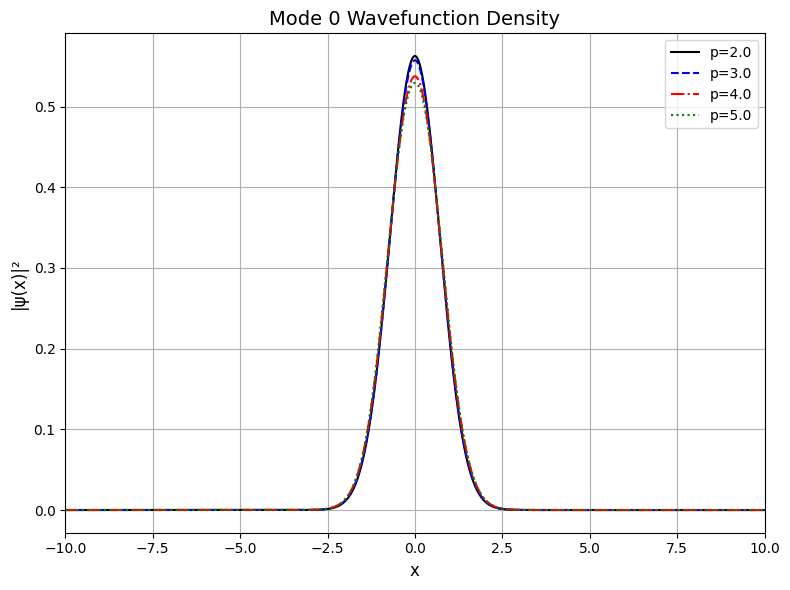

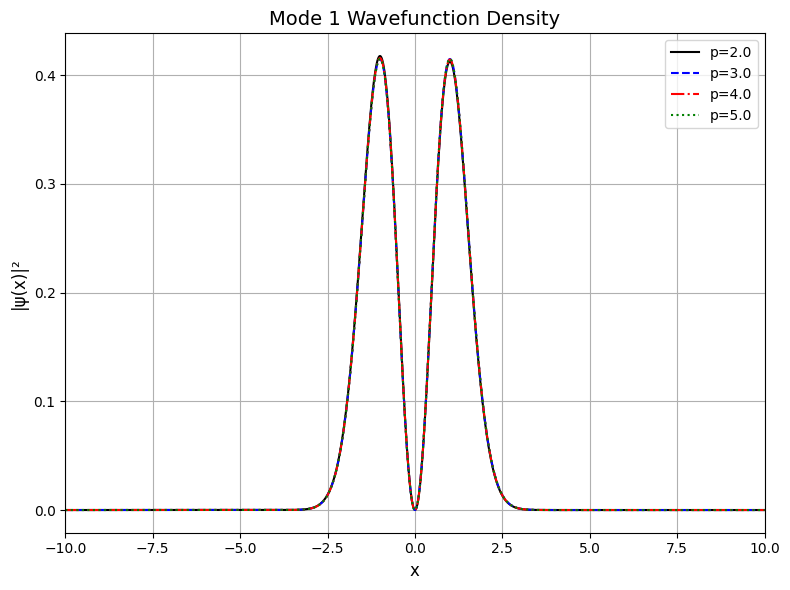

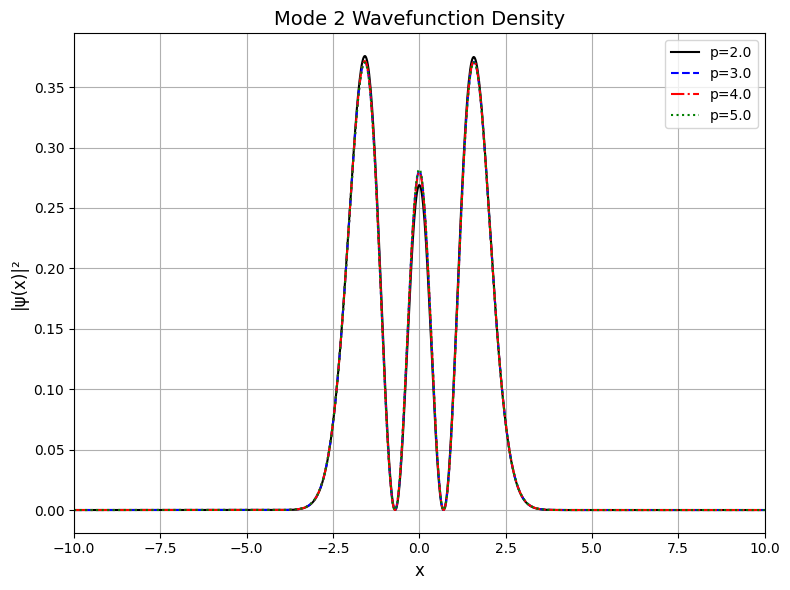

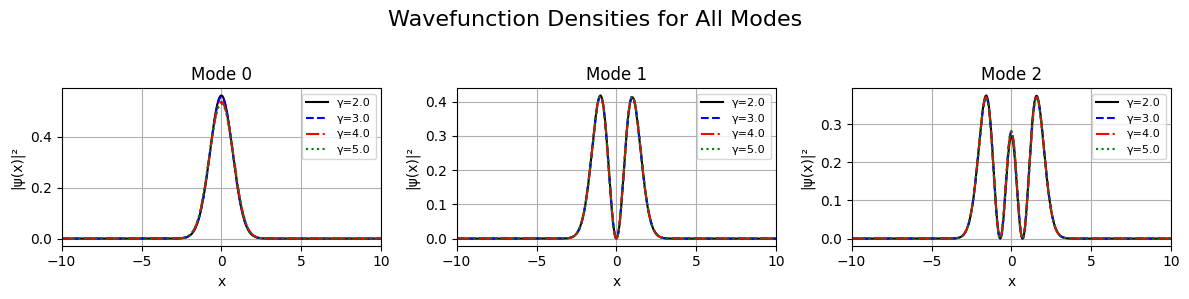

In [73]:
# Plot wavefunction densities for individual modes
print("Generating individual mode plots...")
plot_wavefunction_densities(models_by_mode, X_test, gamma_values, modes, powers)

# Plot μ vs γ for all modes

Generating chemical potential vs. gamma plot...


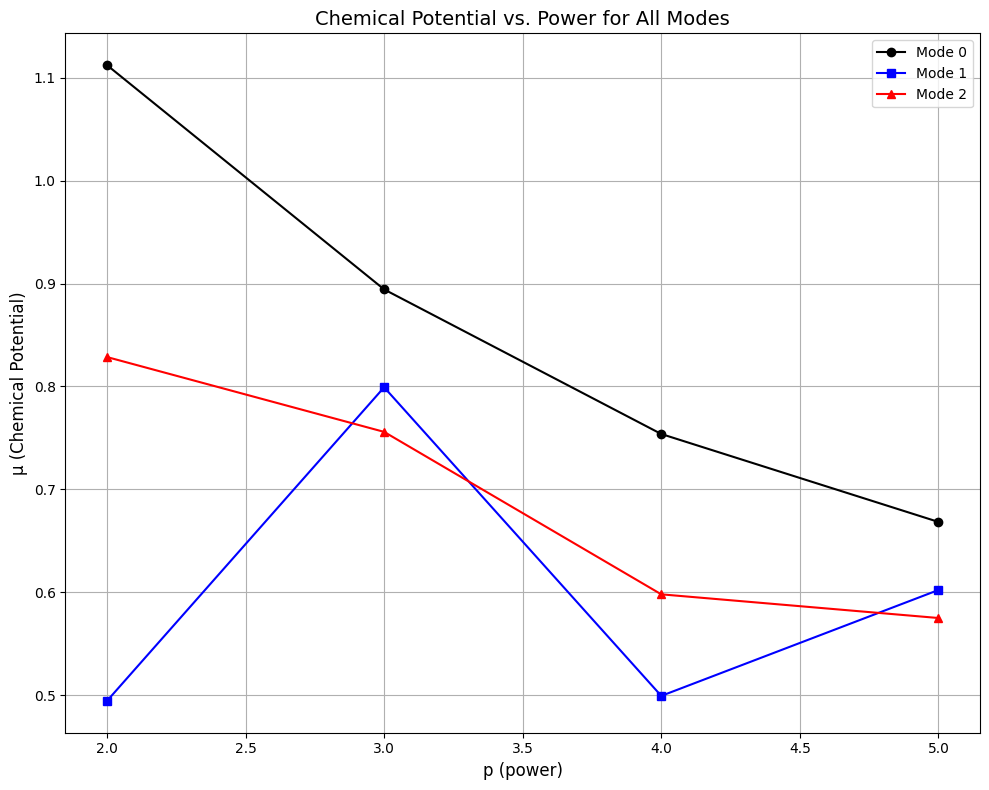

In [74]:
print("Generating chemical potential vs. gamma plot...")
plot_mu_vs_power(mu_table, modes)

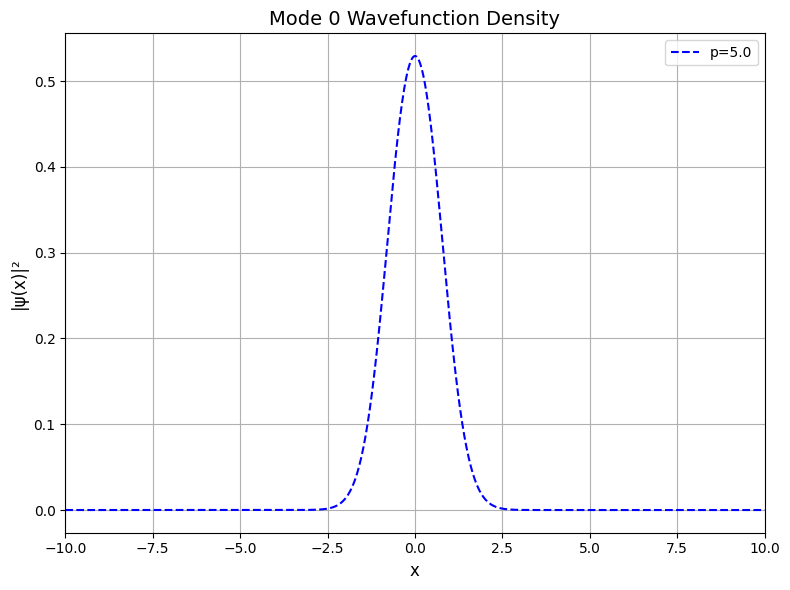

In [75]:
# Create individual figure
power=5
save_dir="plots"
plt.figure(figsize=(8, 6))

X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

# Different line styles and colors
linestyles = ['-', '--', '-.', ':', '-', '--']
colors = ['k', 'b', 'r', 'g', 'm', 'c', 'y', 'orange']

mode=0
model = models_by_mode[mode][power]
model.eval()

with torch.no_grad():
    u_pred = model.forward(X_tensor)
    full_u = model.get_complete_solution(X_tensor, u_pred, mode)
    u_np = full_u.cpu().numpy().flatten()

    # Normalization
    u_np /= np.sqrt(np.sum(u_np ** 2) * dx)

    # Plot wavefunction density
    plt.plot(X_test.flatten(), u_np ** 2,
            linestyle=linestyles[1 % len(linestyles)],
            color=colors[1 % len(colors)],
            label=f"p={power:.1f}")

# Configure individual figure
plt.title(f"Mode {mode} Wavefunction Density", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("|ψ(x)|²", fontsize=12)
plt.grid(True)
plt.legend()
plt.xlim(-10, 10)  # Match paper's range
plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"mode_{mode}_density.png"), dpi=300)
#plt.close()
plt.show()